In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import os
import photutils

### ENTER DATA DIRECTORY AND BAND NAME

In [2]:
datadir = '/home/astrotech1/Desktop/M101/Bdata'
datadir = '/Users/hos/Desktop/Teaching/ASTR306/M101Lab/Bdata'

imfile,calband = 'rpobj0419029.fits','B'
os.chdir(datadir)

### READ IMAGE DATA AND WORLD COORDINATE TRANSFORM FROM HEADER

In [3]:
from astropy.io import fits,ascii
from astropy.wcs import WCS
imhdr=fits.getheader(imfile)
data=fits.getdata(imfile)
wcs=WCS(imhdr)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


### READ LIST OF SDSS CALIBRATING STARS, CONVERT TO B,V PHOTOMETRY

In [4]:
SDSSdat=ascii.read('http://burro.case.edu/Academics/Astr306/M101/SloanStarsM101.dat')
X,Y = wcs.wcs_world2pix(SDSSdat['ra'],SDSSdat['dec'],1)
SDSSdat['X'],SDSSdat['Y'] = X,Y
goodX = np.logical_and(X>50,X<imhdr['NAXIS1']-50)
goodY = np.logical_and(Y>50,Y<imhdr['NAXIS2']-50)
SDSSdat = SDSSdat[np.logical_and(goodX,goodY)]

# convert SDSS mags to Johnson BV mags using Lupton calibration
SDSSdat['B'] = ( SDSSdat['psfMag_g'] + 
                   0.3130*(SDSSdat['psfMag_g']-SDSSdat['psfMag_r']) +
                   0.2271 )
SDSSdat['V'] = ( SDSSdat['psfMag_g'] - 
                   0.5784*(SDSSdat['psfMag_g']-SDSSdat['psfMag_r']) -
                   0.0038 )

### MAKE STAR AND SKY APERTURES (RADII IN PIXELS)

In [5]:
r_star = 8 
rsky_in, rsky_out = 15, 20
positions=[xypos for xypos in zip(SDSSdat['X'],SDSSdat['Y'])]
aperture = photutils.CircularAperture(positions,r=r_star)
annulus_aperture = photutils.CircularAnnulus(positions, r_in=rsky_in, r_out=rsky_out)

### MEASURE MEDIAN SKY LEVEL AROUND ALL STARS

In [6]:
from astropy.stats import sigma_clipped_stats
annulus_masks = annulus_aperture.to_mask(method='center')
bkg_median=[]
for mask in annulus_masks:
    annulus_data = mask.multiply(data)
    annulus_data_1d = annulus_data[mask.data>0]
    mean,med,sig = sigma_clipped_stats(annulus_data_1d)
    bkg_median.append(med)
bkg_median = np.array(bkg_median)
SDSSdat['sky'] = bkg_median

### MEASURE SKY-CORRECTED FLUX FROM STAR

In [7]:
phot = photutils.aperture_photometry(data, aperture)
SDSSdat['flux'] = phot['aperture_sum'] - bkg_median*aperture.area

### CALCULATE INSTRUMENTAL MAGS AND PLOT INST-TRUE MAGS VERSUS COLOR

Text(0, 0.5, '$m_i-B$')

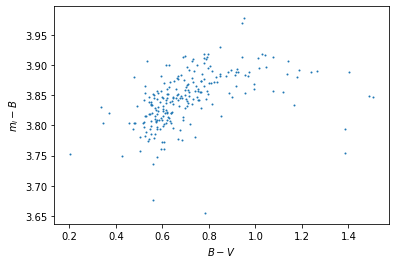

In [8]:
instmag=-2.5*np.log10(SDSSdat['flux'])+2.5*np.log10(float(imhdr['EXPTIME']))+25
diff=instmag-SDSSdat[calband]
plt.scatter(SDSSdat['B']-SDSSdat['V'],diff,s=1)
plt.xlabel(r'$B-V$')
plt.ylabel(r'$m_i-{}$'.format(calband))

### FIT LINE TO MAG-COLOR PLOT IN COLOR RANGE 0.4 < B-V < 0.8

In [9]:
from astropy.modeling import models, fitting
from astropy.stats import sigma_clip

# initialize a linear fitter
fitter = fitting.LevMarLSQFitter()
# initialize the outlier removal fitter
or_fit = fitting.FittingWithOutlierRemoval(fitter, sigma_clip, niter=3, sigma=3.0)
# initialize a linear model
line_init = models.Linear1D()

# define data to be fit
x=SDSSdat['B']-SDSSdat['V']
y=instmag-SDSSdat[calband]
infit=np.logical_and(x>0.4,x<0.8)

# fit the data with the fitter
fitted_line, mask = or_fit(line_init,x[infit],y[infit])
filtered_data = np.ma.masked_array(y[infit], mask=mask)

# get uncertainties: this assumes no covariance!
err_params = np.sqrt(np.diag(fitter.fit_info['param_cov']))

print('Fit: slope={:.3f} +/- {:.3f}, intercept={:.3f} +/- {:.3f}'.format(fitted_line.slope.value,
                                                                         err_params[0],
                                                                         fitted_line.intercept.value,
                                                                         err_params[1]))

imhdr['ZPOINT']=fitted_line.intercept.value
imhdr['CTERM']=fitted_line.slope.value

Fit: slope=0.262 +/- 0.027, intercept=3.670 +/- 0.017


### PLOT FITTED RELATIONSHIP

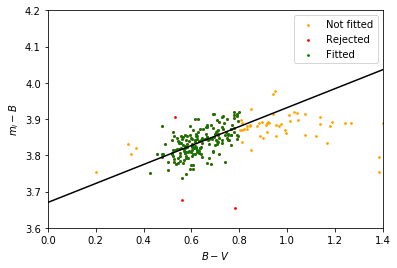

In [10]:
plt.scatter(x[~infit],y[~infit],s=3,color='orange',label='Not fitted')
plt.scatter(x[infit],y[infit],s=3,color='red',label='Rejected')
plt.scatter(x[infit],filtered_data,s=3,color='green',label='Fitted')
xmod=[-0.3,1.5]
plt.plot(xmod,fitted_line(xmod),color='black')
plt.xlim([-0.0,1.4])
plt.ylim([3.6,4.2])
plt.xlabel(r'$B-V$')
plt.ylabel(r'$m_i-{}$'.format(calband))
plt.legend()

### PLOT SKY AS A FUNCTION OF X, AND AS A FUNCTION OF Y

Text(0, 0.5, 'SKY')

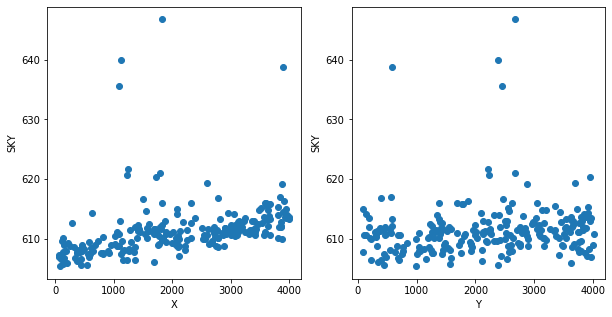

In [11]:
Fig=plt.figure(figsize=(10,5))

Xplot=Fig.add_subplot(121)
Xplot.scatter(SDSSdat['X'],SDSSdat['sky'])
Xplot.set_xlabel('X')
Xplot.set_ylabel('SKY')

Yplot=Fig.add_subplot(122)
Yplot.scatter(SDSSdat['Y'],SDSSdat['sky'])
Yplot.set_xlabel('Y')
Yplot.set_ylabel('SKY')

### FIT A PLANE TO SKY LEVELS AS A FUNCTION OF X,Y POSITION

In [12]:
# initialize a linear model
plane_init = models.Planar2D()

# define data to be fit
x=SDSSdat['X']
y=SDSSdat['Y']
z=SDSSdat['sky']

# fit the data with the fitter
fitted_plane, mask = or_fit(plane_init,x,y,z)
filtered_data = np.ma.masked_array(z, mask=mask)
err_params = np.sqrt(np.diag(fitter.fit_info['param_cov']))

print('Model: Sky[X,Y] = Sky0 + dSkyX * X + dskyY * Y')
print('Fit:   Sky0={:.3f} +/- {:.3f}, dSkyX={:.3e} +/- {:.3e}, dSkyY={:.3e} +/- {:.3e}'.format(
      fitted_plane.intercept.value,err_params[2],
      fitted_plane.slope_x.value,err_params[0],
      fitted_plane.slope_y.value,err_params[1]))

imhdr['SKYDX']=fitted_plane.slope_x.value
imhdr['SKYDY']=fitted_plane.slope_y.value   
imhdr['SKY0']=fitted_plane.intercept.value

Model: Sky[X,Y] = Sky0 + dSkyX * X + dskyY * Y
Fit:   Sky0=606.504 +/- 0.265, dSkyX=1.468e-03 +/- 8.219e-05, dSkyY=4.401e-04 +/- 8.428e-05


### PLOT RESIDUALS FROM MODEL

DIFF: Mean = -0.00 (AVG), Median = -0.15, stdev = 1.43


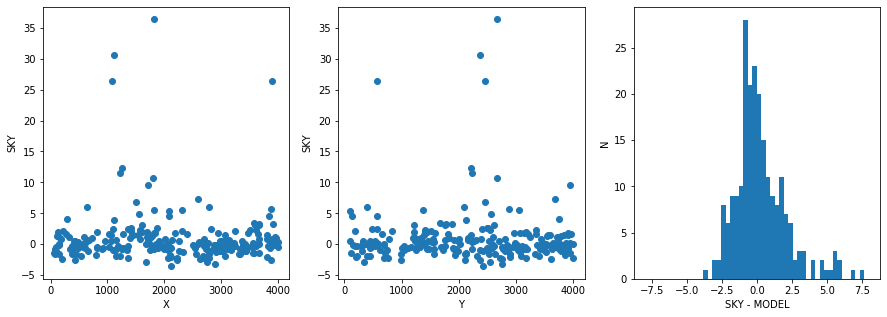

In [13]:
skymodel=fitted_plane(SDSSdat['X'],SDSSdat['Y'])
diff=SDSSdat['sky']-skymodel

Fig=plt.figure(figsize=(15,5))

Xplot=Fig.add_subplot(131)
Xplot.scatter(SDSSdat['X'],diff)
Xplot.set_xlabel('X')
Xplot.set_ylabel('SKY')

Yplot=Fig.add_subplot(132)
Yplot.scatter(SDSSdat['Y'],diff)
Yplot.set_xlabel('Y')
Yplot.set_ylabel('SKY')

HistPlot=Fig.add_subplot(133)
HistPlot.set_xlabel('SKY - MODEL')
HistPlot.set_ylabel('N')
plt.hist(diff,range=(-8,8),bins=50)

from astropy.stats import sigma_clipped_stats
mean,med,stdev=sigma_clipped_stats(diff,sigma=3.0)
print('DIFF: Mean = {:.2f} (AVG), Median = {:.2f}, stdev = {:.2f}'.format(mean,med,stdev))

### SUBTRACT SKY FROM IMAGE AND WRITE SUBTRACTED IMAGE

In [14]:
X, Y = np.meshgrid( np.arange(1,imhdr['NAXIS1']+1) ,
                    np.arange(1,imhdr['NAXIS2']+1) )

data -= fitted_plane(X,Y)
hdu = fits.PrimaryHDU(data,header=imhdr)
hdu.writeto('c'+imfile,overwrite=True)